# **Individual Project Planning**

## **1) Data Description**

#### **PLAYERS.CSV**
**Number of Observations**: 196

**Number of Variables**: 9
| Variable | Data Type | Meaning | Issues | How Data was Collected |
|----------|-----------|---------|--------|------------------------|
| experience | character | Player's experience with Minecraft | Data type should be factor and not character as there is a limit of 5 possible value options | Collected during sign up |
| subscribe | logical | True or false depending on whether the player has subscribed to PLAIcraft's email updates | NA | Collected during sign up | 
| hashedEmail | character | Hashed version of the email the player signed up with | NA | Collected during sign up |
| played_hours | double | Total number of hours played by player | NA | Recorded by summing up hours played in each of the player's sessions. The session data is tracked in sessions.csv |
| name | character | Chosen in-game name of player | NA | Collected during sign up |
| gender | character | Player's gender | Data type should be factor and not character as there is a limit of 7 possible value options | Collected during sign up |
| age | double | Player's age | NA | Collected during sign up |

Another issue with variables *experience*, *gender*, and *age* are that there is nothing in the sign up that prevents players from providing false information.

Ignored *individualId* and *organizationName* because no values were provided for a single cell within their respective columns.

#### **SESSIONS.CSV**
**Number of Observations**: 1535

**Number of Variables**: 5
| Variable | Data Type | Meaning | Issues | How Data was Collected |
|----------|-----------|---------|--------|------------------------|
| hashedEmail | character | Hashed version of the email the player signed up with | NA | Collected during sign up |
| start_time | character | Date and time of when this session started | Data type should be datetime and not character | Converted from the original_start_time column to be in a human readable format |
| end_time | character | Date and time of when this session ended | Data type should be datetime and not character | Converted from the original_end_time column to be in a human readable format |
| original_start_time | double | Date and time of when this session started (in UNIX timestamp format) | NA | Collected when a player logs in and starts on session on the PLAIcraft server |
| original_end_time | double | Date and time of when this session ended (in UNIX timestamp format) | NA | Collected when a player logs out and ends their current session on the PLAIcraft server |

## **2) QUESTION**

**Question**: Which types of people (qualities in consideration: age, experience, and gender), contribute the longest average session times to the PLAICraft server? (Based off Question 1 of the provided ones)

The data itself provides the explanatory variables: age, experience, and gender. 

The response variable can be obtained by:
1. Converting the start_time and end_time columns in the sessions table to datetime type
2. Creating a new column in the sessions table that is the difference between the end_time and start_time
3. Calculating the average session time for each of the unique hashedEmail values
4. Joining that table by hashedEmail with the players.csv table

## **3) Exploratory Data Analysis and Visualization**

In [1]:
library(tidyverse)
library(tidymodels)
library(scales)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 12, repr.plot.height = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
url_sessions <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
clean_player_data <- read_csv(url_players) |>
            mutate(experience = as.factor(experience)) |>     # Convert experience to factor data type
            mutate(gender = as.factor(gender)) |>     # Convert gender to factor data type
            select(-individualId, -organizationName)     # Remove unneeded columns
clean_session_data <- read_csv(url_sessions) |>
                mutate(session_start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>     # Convert start_time to datetime data type
                mutate(session_end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")) |>      # Convert end_time to datetime data type
                select(-original_start_time, -original_end_time, -start_time, -end_time)     # Remove unneeded columns
clean_player_data
clean_session_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91


hashedEmail,session_start_time,session_end_time
<chr>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00
⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00


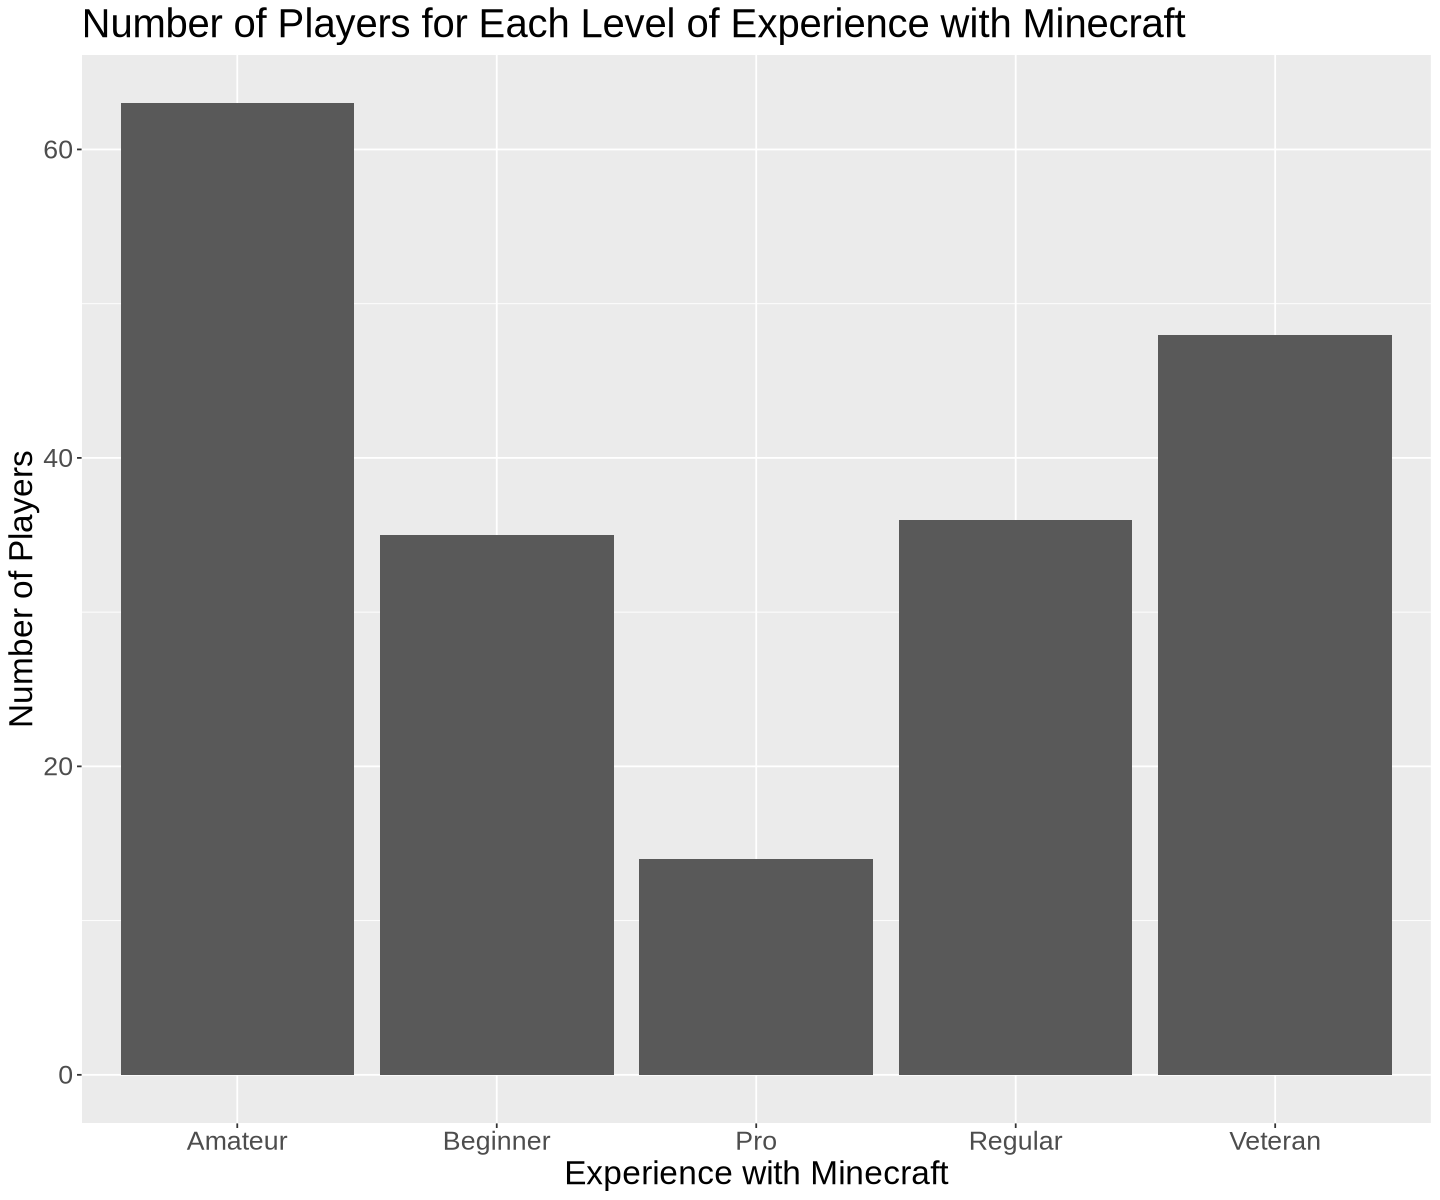

In [3]:
experience_count_plot <- ggplot(clean_player_data, aes(x = experience)) +
                        geom_bar() +
                        labs(x = "Experience with Minecraft", y = "Number of Players", title = "Number of Players for Each Level of Experience with Minecraft") +
                        theme(text = element_text(size = 20))
experience_count_plot

Observations:
- Sizeable difference in players between amateur and pro
- Number of players amongst experience levels is not very equal

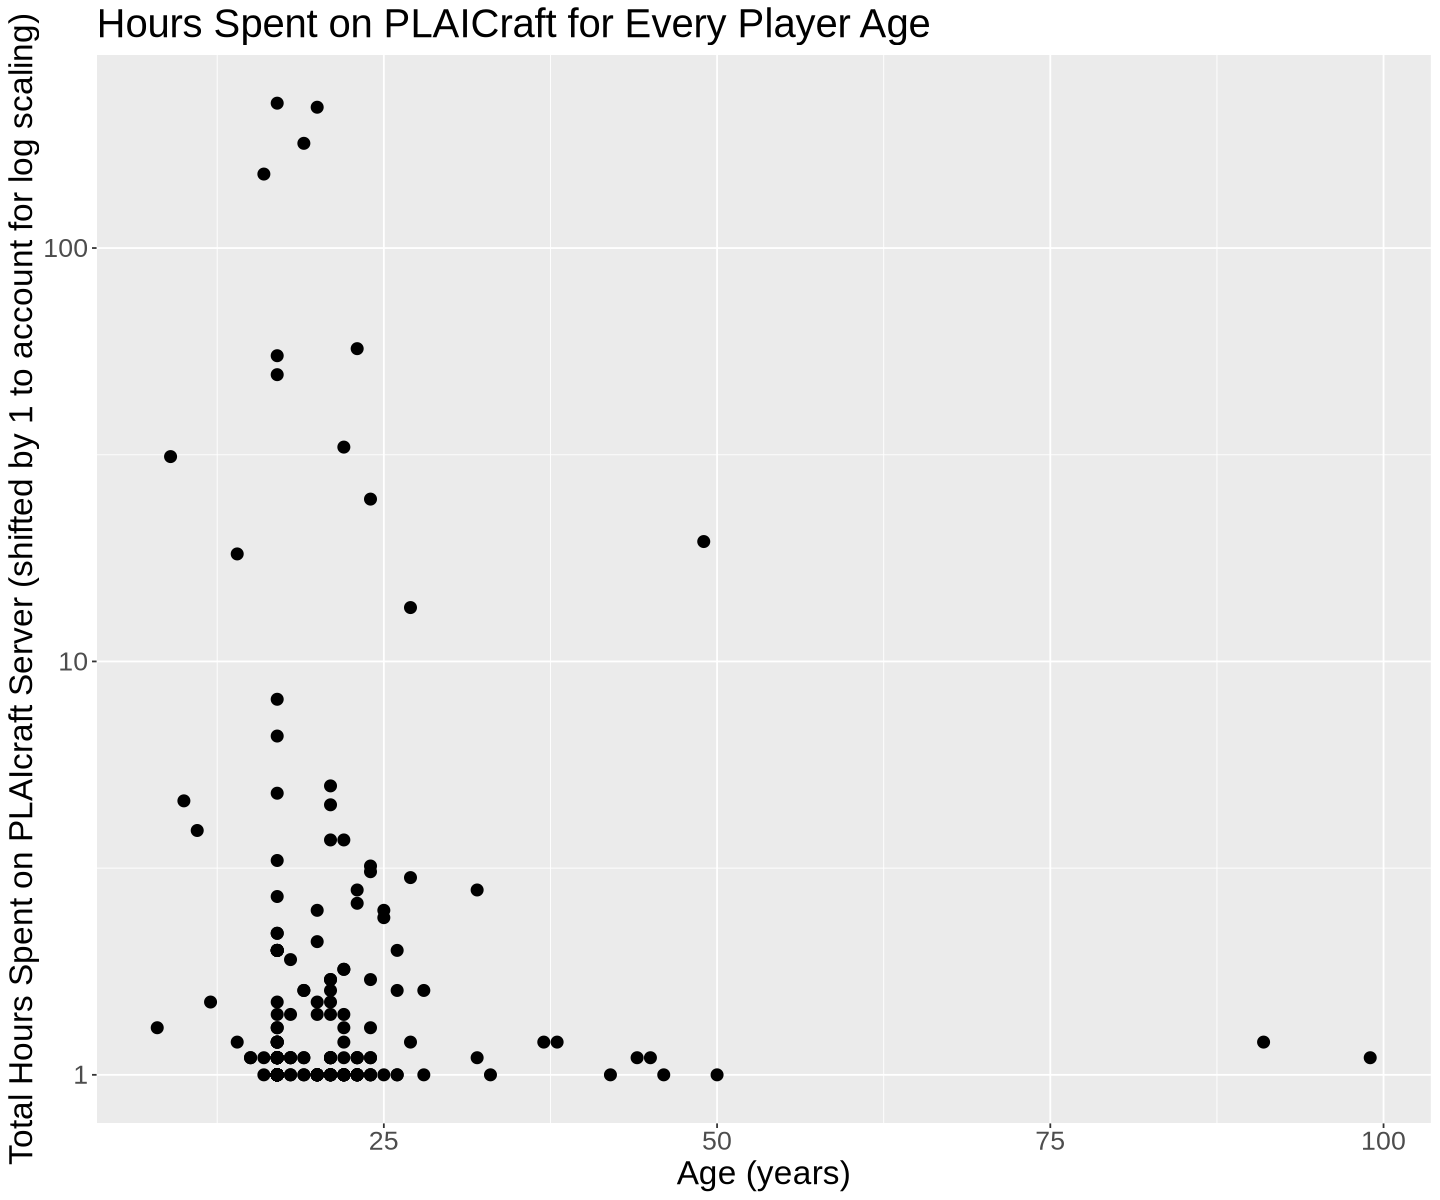

In [4]:
age_plot <- ggplot(clean_player_data, aes(x = age, y = played_hours + 1)) +
                geom_point(size = 3) +
                labs(x = "Age (years)", y = "Total Hours Spent on PLAIcraft Server (shifted by 1 to account for log scaling)", title = "Hours Spent on PLAICraft for Every Player Age") +
                theme(text = element_text(size = 20)) + 
                scale_y_log10(labels = label_comma())
age_plot

Observations:
- Majority players fall between age 15-26
- Majority of hours come from range 15-26
- Majority of total playing time falls between 0 to 10 hours
- No data between ages 50 to 80.

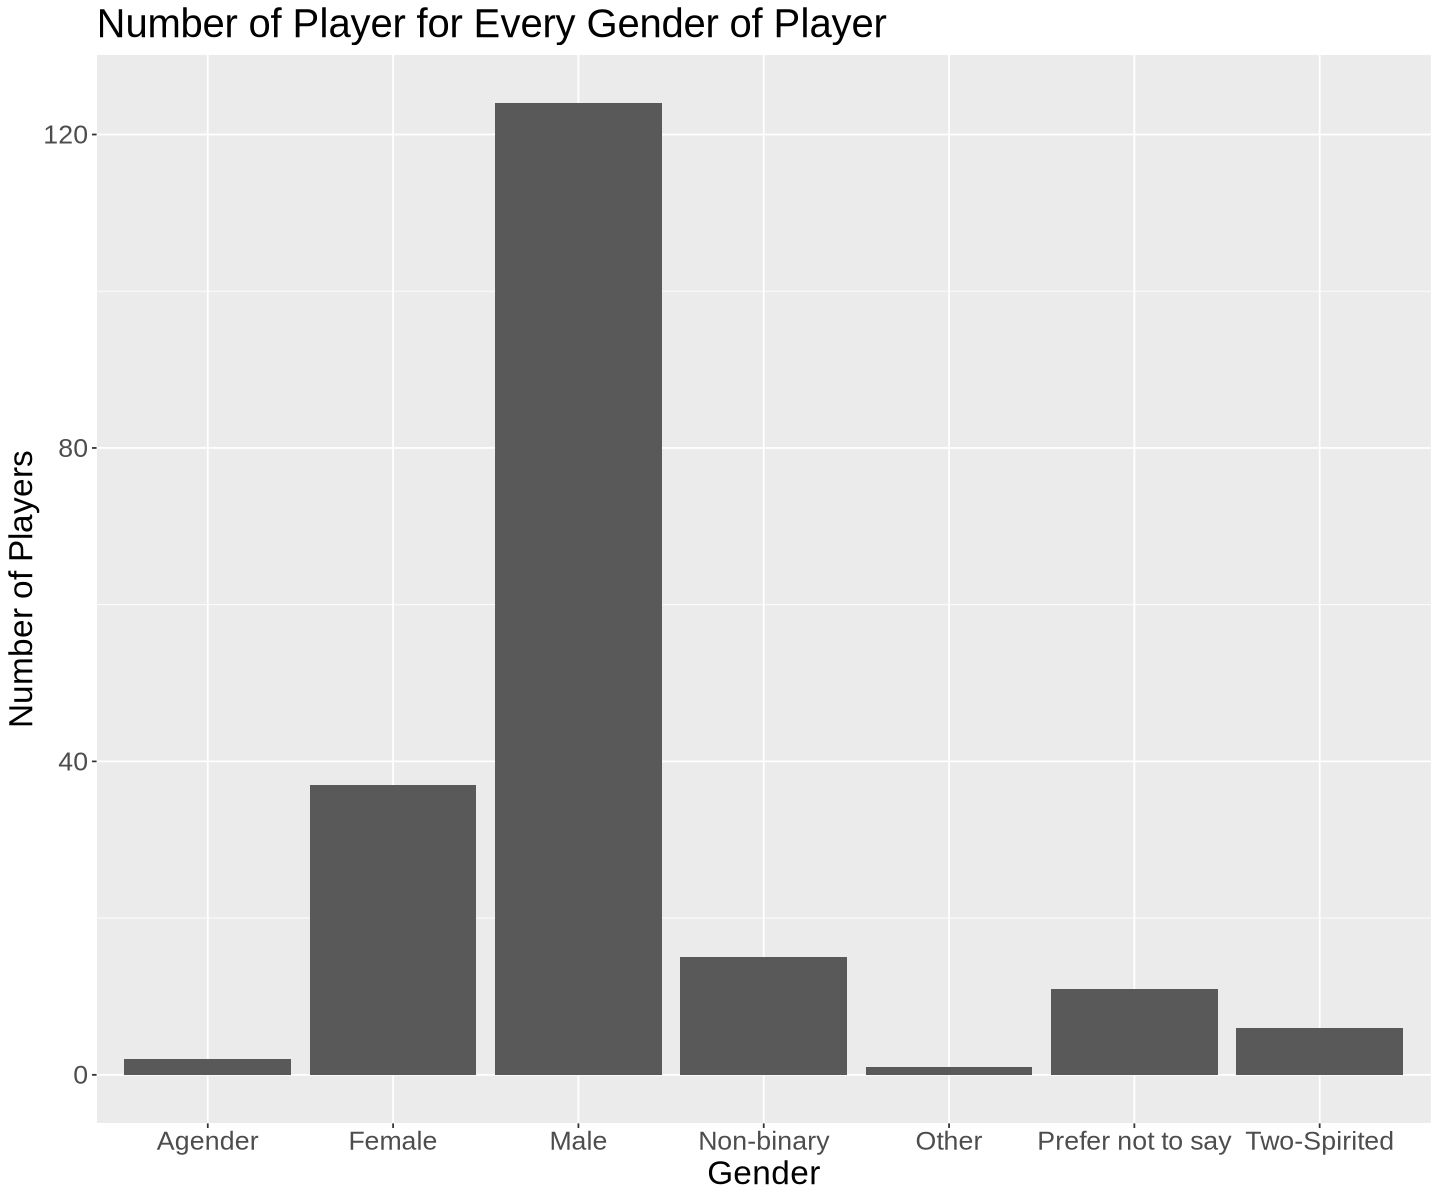

In [5]:
gender_count_plot <- ggplot(clean_player_data, aes(x = gender)) +
                        geom_bar() +
                        labs(x = "Gender", y = "Number of Players", title = "Number of Player for Every Gender of Player") +
                        theme(text = element_text(size = 20))
gender_count_plot

Observations:
- Large disparity between males and every other gender

## **4) Methods and Plan**

I will use knn regression. A regression model was chosen because the response variable is quantitative. Then based on my preliminary analysis of the data in part (3) it seems unlikely that there is a linear relationship between the explanatory variables and response variable, because of that knn regression would be the best option. However, I will confirm this choice after wrangling my data according to the steps in part (2) by creating visualizations that compare my explanatory variables with the response variable. There aren't any assumptions to make due to using knn. A weakness of this method is that we can't interpret the line that the knn model will create, unlike the linear model. Another weakness is that it won't be able to predict the response variable very well where there are gaps in our data. In order to select the best knn model I will use cross validation with 5 folds and then select the k value of lowest RMSE. To prepare my data for the model I will split the data into two: 75% for training and 25% for testing. I will perform the split after I have wrangled my data (according to part (2)).